## Import packages and set general variables

In [2]:
import os
import math
import mdtraj as mdt
import dynetan
from dynetan.toolkit import *
from dynetan.viz import *
from dynetan.proctraj import *
from dynetan.gencor import *
from dynetan.contact import *
from dynetan.datastorage import *
from itertools import islice
from scipy import stats
import pandas as pd
import numpy as np
import scipy as sp
# For visualization
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mat
import networkx.algorithms.community.quality as nxquality
#
import sklearn as skl
from sklearn.manifold import MDS

In [3]:
main_folder='./' # edit with the full local path to this folder
test_folder='./test_outputs/' # set it to a folder where to write outputs from this Notebook


In [4]:
# edit with the name of the system to analyze (AR, A2A or EGFR)
case_study="EGFR"
fileNameRoot="EGFR"

## DyNet Analysis 

This analysis uses the dynetan software package, which has been developed in [1]. In particular, the analysis is divided in two subsequent steps, and has been adapted from the Jupyter Notebooks provided as Supplementary material of the original article.  
  
[1] Melo, MCR et al., Generalized correlation-based dynamical network analysis: a new high-performance approach for identifying allosteric communications in molecular dynamics trajectories, _The Journal of chemical physics_, __2020__

__NB:__ EXECUTING STEP 1 REQUIRES THE ORIGINAL TRAJECTORIES FROM OUR SIMULATIONS AND IS COMPUTATIONALLY DEMANDING (HOURS). fOR SIMPLICITY, WE PROVIDE THE OUTPUTS FROM THIS STEP IN THE ANALYSIS FOLDER, SO YOU CAN START RIGHT AWAY AT STEP 2, WHERE YOU WILL LOAD SUCH FILES. 

### Step 1

In [ ]:
# Create the object that processes MD trajectories.
dnap = DNAproc()

In [3]:
# Path where input files will searched and results be written.
workDir = main_folder+case_study+"/md_outputs/"

# GRO file name
psfFile = os.path.join(workDir, "production_prot.gro")
#psfFile = os.path.join(workDir, "prod_100_prot.pdb")

# XTC file name
#dcdFiles = [os.path.join(workDir, "prod_100_prot.xtc")]
dcdFiles = [os.path.join(workDir, "production_prot.xtc")]

In [4]:
# Segment IDs for regions that will be studied.
segIDs = ['SYSTEM']
#segIDs=['A']

# Residue name for solvent molecule(s)
h2oName = ["TIP3"]

In [7]:
# Number of windows created from full simulation.
numWinds = 1

# Sampled frames per window
numSampledFrames = 500001

In [8]:
# Network Analysis will make one node per protein residue (in the alpha carbon)
# For other residues, the user must specify atom(s) that will represent a node.
customResNodes = {}
customResNodes["TIP3"] = ["OH2"]

# We also need to know the heavy atoms that compose each node group.
usrNodeGroups={}

# Cutoff for contact map (In Angstroms)
cutoffDist = 5.5

# Minimum contact persistance (In ratio of total trajectory frames)
contactPersistence = 0.75

#################################
### Load info to object

dnap.setNumWinds(numWinds)
dnap.setNumSampledFrames(numSampledFrames)
dnap.setCutoffDist(cutoffDist)
dnap.setContactPersistence(contactPersistence)
dnap.seth2oName(h2oName)
dnap.setSegIDs(segIDs)

dnap.setCustomResNodes(customResNodes)
dnap.setUsrNodeGroups(usrNodeGroups)

### The method `setCustomResNodes` is now deprecated.


In [9]:
dnap.loadSystem(psfFile,dcdFiles)
# We can access the trajectory data directly.
print(dnap.getU().trajectory)
print(dnap.checkSystem())

<ChainReader containing nores_prova.xtc with 84 frames of 4780 atoms>
Residue verification:

---> SegID  SYSTEM : 23 unique residue types:
{'ILE', 'GLN', 'HID', 'TYR', 'HIP', 'CYS', 'VAL', 'LYS', 'HIE', 'GLU', 'PRO', 'ALA', 'CYX', 'MET', 'TRP', 'ARG', 'LEU', 'ASN', 'THR', 'GLY', 'ASP', 'PHE', 'SER'}

---> 23 total selected residue types:
{'ILE', 'MET', 'GLN', 'TRP', 'HID', 'TYR', 'ARG', 'LEU', 'HIP', 'CYS', 'ASN', 'THR', 'VAL', 'GLY', 'LYS', 'ASP', 'PHE', 'HIE', 'SER', 'GLU', 'PRO', 'ALA', 'CYX'}

---> 0 not-selected residue types in other segments:
set()

---> 23 total residue types:
{'ILE', 'MET', 'GLN', 'TRP', 'HID', 'TYR', 'ARG', 'LEU', 'HIP', 'CYS', 'ASN', 'THR', 'VAL', 'GLY', 'LYS', 'ASP', 'PHE', 'HIE', 'SER', 'GLU', 'PRO', 'ALA', 'CYX'}

---> 305 total residues were selected for network analysis.

Segments verification:

---> 1 selected segments:
['SYSTEM']

---> 0 not-selected segments:
[]

None


In [10]:
# Automatically identify crystallographic waters and ions
dnap.selectSystem(withSolvent=False)

The initial universe had 4780 atoms.
The final universe has 2357 atoms.
Loading universe to memory...


In [11]:
# Prepare network representation of the system
dnap.prepareNetwork()
# If your system is too large, you can turn off the "in memory" option, at a cost for performance.
dnap.alignTraj(inMemory=True)
# Align the trajectory based on selected segments
# If your system is too large, you can turn off the "in memory" option, at a cost for performance.
dnap.alignTraj(inMemory=True)
# Select residues that are closer than 4.5A for more than 75% of simulation
# To speed-up the contact matrix calculation, a larger stride can be selected, at a cost for precision.
dnap.findContacts(stride=1)
# Removing contacts between nodes in the same residue
dnap.filterContacts(notSameRes=True, notConsecutiveRes=False, removeIsolatedNodes=True)

Preparing nodes...


Nodes:   0%|          | 0/305 [00:00<?, ?it/s]

Nodes are ready for network analysis.


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Window:   0%|          | 0/1 [00:00<?, ?it/s]

We found 0 nodes with no contacts.
We found 1709 contacting pairs out of 46360 total pairs of nodes.
(That's 3.7%, by the way)


Window:   0%|          | 0/1 [00:00<?, ?it/s]

Node:   0%|          | 0/305 [00:00<?, ?it/s]

Window: 0
We found 1709 contacting pairs out of 46360 total pairs of nodes.
(That's 3.686%, by the way)

Removing isolated nodes...

We found 0 nodes with no contacts.

Isolated nodes removed. We now have 305 nodes in the system

Running new contact matrix sanity check...
We found 0 nodes with no contacts.
We found 1709 contacting pairs out of 46360 total pairs of nodes.
(That's 3.7%, by the way)

Updating Universe to reflect new node selection...
Updating atom-to-node mapping...


Node:   0%|          | 0/305 [00:00<?, ?it/s]

In [13]:
# Calculate Generalized Correlation with Python/Numba
# We can calculate generalized correlaions in parallel using Python's multiprocessing package.
dnap.corrMatAll=None
dnap.calcCor(ncores=1)

Calculating correlations...

Using window length of 84 simulation steps.
- > Using single-core implementation.


Window:   0%|          | 0/1 [00:00<?, ?it/s]

Contact Pair:   0%|          | 0/1709 [00:00<?, ?it/s]

In [14]:
# Calculate cartesian distances between all nodes in the selected system
# We can leverage MDanalysis parallelization options with backend="serial" or backend="openmp".
# For very small systems, the serial can be faster!
dnap.calcCartesian(backend="serial")
# Network Calculations
dnap.calcGraphInfo()
A=nx.adjacency_matrix(dnap.nxGraphs[0])

Calculating cartesian distances...

Sampling a total of 50 frames from 1 windows (50 per window)...


MEAN: Timesteps:   0%|          | 0/50 [00:00<?, ?it/s]

SEM/MIN/MAX: Timesteps:   0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_360155/3151990749.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(dnap.nxGraphs[0])
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [20]:
# Calculate optimal paths
dnap.calcOptPaths(ncores=4)
# Calculate betweenness
dnap.calcBetween(ncores=4)
# Eigenvecotor
dnap.calcEigenCentral()
# Calculate communities
dnap.calcCommunities()

Window:   0%|          | 0/1 [00:00<?, ?it/s]

Window:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Save the data
pathToData = main_folder+case_study+'/analysis/'
dnap.saveData(pathToData)

MDAnalysis may print warnings regarding missing data fields, such as altLocs, icodes, occupancies, or tempfactor, which provide information commonly found in PDB files. The warnings are for your information and in the context of this tutorial they are expected and do not indicate a problem.


### Step2

In [4]:
dnad = DNAdata()

In [5]:
# Files and system definitions 
dataDir = main_folder+case_study+"/analysis"
# Path where results will be written 
workDir = main_folder+case_study+"/analysis"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
# Load data
dnad.loadFromFile(fullPathRoot)

atomToNode int64 (2311,) 2311
contactMat int64 (289, 289) 83521
corrMatAll float64 (1, 289, 289) 83521
distsAll float64 (1, 289, 289) 83521
maxDirectDist float64 () 1
maxDist float64 () 1
nodeDists float64 (4, 41616) 166464
nodesIxArray int64 (289,) 289
numNodes int32 () 1


### Compute correlation

In [285]:
traj=mdt.load(main_folder+case_study+'/analysis/'+case_study+'_prot.gro')

__NB:__ The script below needs the dictionary with the pockets as lists, so we read them as lists.

In [286]:
# raguti get pockets (AS A LIST)
file=open(main_folder+case_study+'/analysis/pocketron_pockets_'+case_study+'.txt','r')
file.readline()
pockets={}
i=0
for line in file:
    p1=[]
    i+=1
    line=line.split()
    for element in line:
        if element!='\n':
            p1.append(int(element)-1)
            res=np.array([a.residue.index for a in traj.top.atoms if a.index in p1])
            res=np.unique(res)
    temp=[]
    resid=[]
    for value in res:
        temp.append(int(value)+1)
    resid.append(temp)
    pockets.update({i:resid[0]})
last_key = list(pockets)[-1]
removed_tuple = pockets.pop(last_key)

In [287]:
n_pockets=len(pockets)

In [10]:
# set functions used in the code window right below for the computation
# of the DyNet matrix
def check_rep(i,j):
    test=False
    for element in i:
        if element in j:
            test=True
    return test

def all_in_one(i,j):
    index=[]
    check_rep=np.isin(i,j)
    position=0
    for element in check_rep:
        if element==True:
            index.append(position)
        position+=1
    for element in sorted(index, reverse=True):
        del i[element]
    return i

def calc_sum_btws(element,j,btws,sum):
    for element2 in j:
        if int(element)<int(element2):
            if (int(element),int(element2)) in btws:
                #print(element,element2)
                sum+=float(btws[int(element),int(element2)])
        else:
            if (int(element2),int(element)) in btws:
                #print(element2,element)
                sum+=float(btws[int(element2),int(element)])
    return sum

def remove_empty(temp):
    a=[]
    for i in range(len(temp)):
        a.append(list(temp.keys())[i])
    for element in a:
        if temp[element]==0:
            del temp[element]
    return temp

In [11]:
# compute DyNet matrix, coarse grained in pockets
i=1
flux_norep={}
flux_a={}
flux_b={}
sum=0
while i<len(pockets)+1:
    j=1
    while j<len(pockets)+1:
        test=check_rep(pockets[i],pockets[j])
        sum_a=0
        sum_b=0
        tot=0
        if test==True:
            pocket_norep_a=all_in_one(pockets[i].copy(),pockets[j])
            pocket_norep_b=all_in_one(pockets[j].copy(),pockets[i])
            for element in pocket_norep_a:
                if i>j:
                    sum_a+=calc_sum_btws(element,pockets[j],dict(dnad.btws[0]),0)
            for element in pocket_norep_b:
                if i>j:
                    sum_b+=calc_sum_btws(element,pockets[i],dict(dnad.btws[0]),0)   
        else:
            for element in pockets[i]:
                if i>j:
                    #print(i,j)
                    tot+=calc_sum_btws(element,pockets[j],dict(dnad.btws[0]),0)
        flux_norep.update({(i,j):tot})
        flux_a.update({(i,j):sum_a})
        flux_b.update({(i,j):sum_b})
        j+=1
    i+=1
flux_norep=remove_empty(flux_norep)
flux_a=remove_empty(flux_a)
flux_b=remove_empty(flux_b)
flux_ab={}
for key in flux_a.keys():
    if key in flux_b:
        flux_ab[key]=np.max((flux_a[key],flux_b[key]))
    else:
        flux_ab[key]=flux_a[key]
mat_abn=np.zeros((len(pockets),len(pockets)))
for key in flux_ab.keys():
    mat_abn[key[0]-1,key[1]-1]=flux_ab[key]
for key in flux_norep.keys():
    mat_abn[key[0]-1,key[1]-1]=flux_norep[key]

In [12]:
mat_dynet=mat_abn+mat_abn.T

In [13]:
mat_dynet=mat_dynet/np.max(mat_dynet)

In [14]:
np.savetxt(test_folder+'matrix_dynet_'+case_study+'.txt',mat_dynet,fmt='%.9f')

In [15]:
mat_dynet[0]

array([0.        , 0.03288342, 0.22165558, 0.        , 0.        ,
       0.19431762, 0.29182545, 0.24015585, 0.06622368, 0.41748345,
       0.04966779, 0.12638682, 0.0235126 , 0.        , 0.00423334,
       0.30468416, 0.10449508, 0.02185311, 0.03597978, 0.04762463,
       0.0514985 , 0.01517481, 0.        , 0.        , 0.0844704 ,
       0.1808626 , 0.03343887, 0.18782279, 0.        , 0.27786954,
       0.00423334, 0.        , 0.19100924, 0.1458495 , 0.        ,
       0.        , 0.2031092 , 0.03550274, 0.04252913, 0.14831794,
       0.04168262, 0.        , 0.10024527, 0.50096078, 0.2121962 ,
       0.09819908, 0.24310907, 0.01792981, 0.13211887, 0.25325292,
       0.02009172, 0.12818383, 0.23493075, 0.        , 0.21290329,
       0.        , 1.        , 0.03612713, 0.0409445 , 0.02183616])

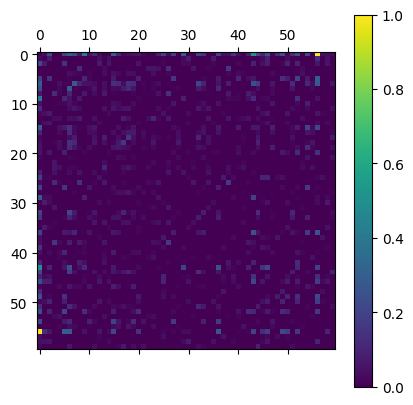

In [16]:
plt.matshow(mat_dynet)
plt.colorbar()
plt.show()

In [17]:
# Uncomment depending on the case_study

#axis_labels_a2a=[5,10,15,20,25,30,35,40,45,50,55]
#axis_labels_ar=[5,10,15,20,25,30,35,40,45,50]
axis_labels_egfr=[5,10,15,20,25,30,35,40,45,50,55,60]

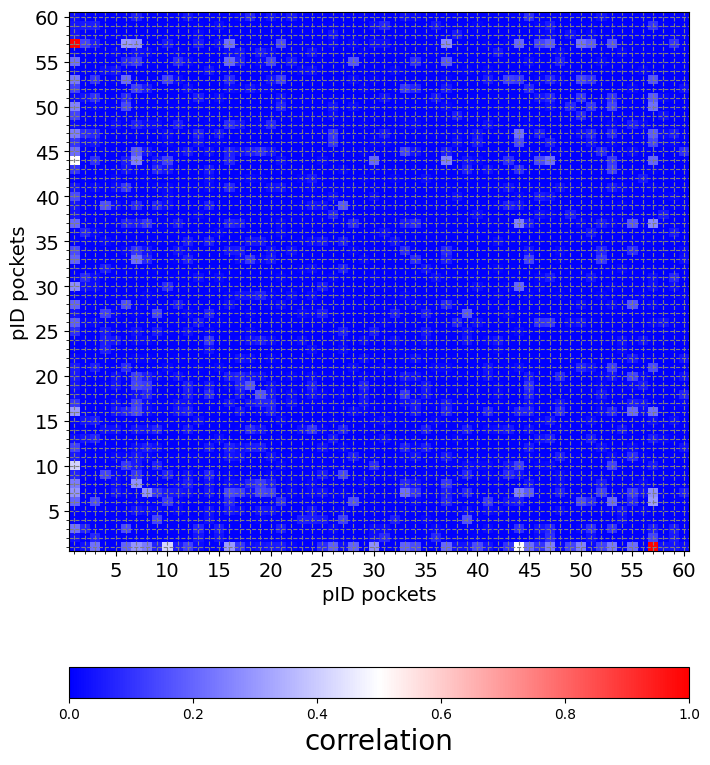

In [18]:
fig = plt.figure(figsize=(8,10))
ax = plt.axes()
cmap = mat.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

surf = ax.pcolormesh(np.linspace(1,n_pockets,n_pockets),np.linspace(1,n_pockets,n_pockets), 
                     mat_dynet,shading='nearest',cmap=cmap) # , vmin=0, vmax=25

plt.colorbar(surf,orientation="horizontal",pad=0.15).ax.set_xlabel('correlation', fontsize=20)

#plt.xticks(axis_labels_a2a,fontsize=14)
#plt.yticks(axis_labels_a2a,fontsize=14)
#plt.xticks(axis_labels_ar,fontsize=14)
#plt.yticks(axis_labels_ar,fontsize=14)
plt.xticks(axis_labels_egfr,fontsize=14)
plt.yticks(axis_labels_egfr,fontsize=14)

plt.xlabel("pID pockets",fontsize=14)
plt.ylabel("pID pockets",fontsize=14)
plt.gca().set_xticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.gca().set_yticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.grid(which='both',ls='--',color='gray') # major, minor, both
#plt.show()
plt.savefig(test_folder+'matrix_dynet_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

### prepare all the stuff to plot in 2D

In [288]:
# compute pocket centers of mass
com={}
for i in range(1,len(pockets)+1):
    string=""
    for element in range(len(pockets[i])):
        string+=" "+str(int(pockets[i][element])-1)
    string="resid"+str(string)
    COM=mdt.compute_center_of_mass(traj, select=string)
    com.update({i:COM})

In [289]:
# just converting the com dictionary to array
com_array=[]
for i in range(1,len(pockets)+1):
    com_array.append(com[i][0])
com_array=np.array(com_array)

In [290]:
com_dmat=sp.spatial.distance_matrix(com_array,com_array)

In [291]:
com_dmat[6,10],com_dmat[6,33]

(1.4828582259309024, 1.021835991071808)

In [24]:
# MDS with random seeds sets
# uncomment depending on system

## a2a, 21
#embedded=MDS(n_components=2,dissimilarity='precomputed',random_state=21).fit_transform(com_dmat)
## ar, 45
#embedded=MDS(n_components=2,dissimilarity='precomputed',random_state=45).fit_transform(com_dmat)
# egfr, 21
embedded=MDS(n_components=2,dissimilarity='precomputed',random_state=21).fit_transform(com_dmat)

/home/mbernett/my_progs/miniconda3/envs/dynetan/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


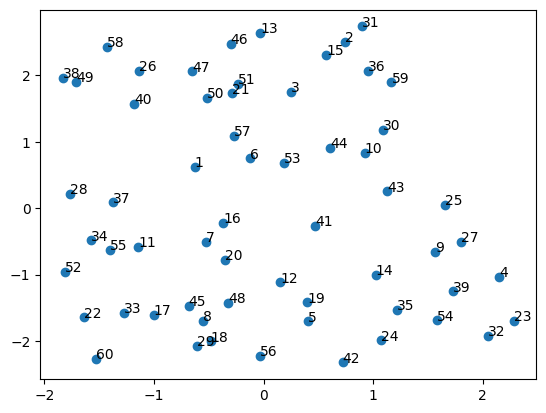

In [25]:
plt.plot(embedded[:,0],embedded[:,1],'o')
for i in range(len(embedded)):
    plt.annotate(i+1,(embedded[i,0],embedded[i,1]))
plt.show()

In [26]:
# to try different rotations of the embedding space to produce figures oriented as desired
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    rotated=np.zeros((x.shape[0],2))
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    rotated[:,0]=xr
    rotated[:,1]=yr
    return rotated #,xr,yr

In [27]:
# uncomment depending on system

## a2a
#rotated=rotate(embedded[:,0],embedded[:,1],0,0,-2.2) # orient vertically (transmembrane-wise)
# ar
#rotated=rotate(embedded[:,0],embedded[:,1],0,0,-np.pi/2)
# for egfr
rotated=rotate(embedded[:,0],embedded[:,1],0,0,0) # no rotation, nice as it is

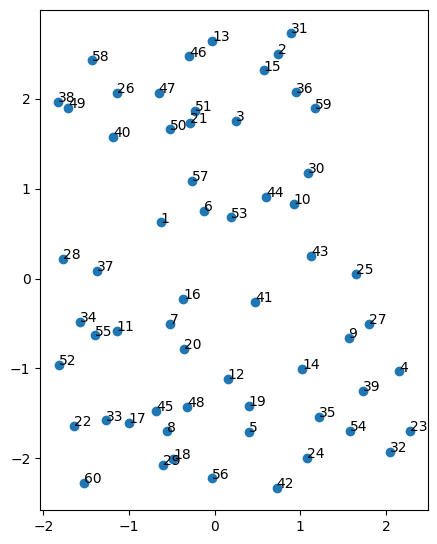

In [28]:
# plot rotated figure to check the result
plt.figure(figsize=(5,6.5))
plt.plot(rotated[:,0],rotated[:,1],'o')
for i in range(len(rotated)):
    plt.annotate(i+1,(rotated[i,0],rotated[i,1]))
plt.show()

In [29]:
# dict_emb={}
# for i in range(len(embedded)):
#     dict_emb[i]=embedded[i]
dict_emb={}
for i in range(len(rotated)):
    dict_emb[i]=rotated[i]

In [30]:
# function to scale ranges, used in different parts of the notebook
def scale_range (inp, minv, maxv):
    inp += -(np.min(inp))
    inp /= np.max(inp) / (maxv - minv)
    inp += minv
    return inp

In [31]:
# load the volumes along the MD trajectory
path=main_folder+case_study
vol_mat=np.loadtxt(path+'/analysis/pocketron_volumes_'+case_study+'.txt',skiprows=1)

In [32]:
avg_vols=[]
for i in range(vol_mat.shape[1]):
    avg_vols.append(np.average(vol_mat[:,i][np.where(vol_mat[:,i]>0.0)]))
avg_vols=np.array(avg_vols)

In [33]:
# uncomment depending on system

#scaled_vols=scale_range(avg_vols,500,1350) # A2A
#scaled_vols=scale_range(avg_vols,350,1200) # AR
scaled_vols=scale_range(avg_vols,250,1100) # EGFR

In [34]:
# compute pocket persistency
raw_persistence=[]
for i in range(vol_mat.shape[1]):
    raw_persistence.append(np.where(vol_mat[:,i]>0.0)[0].shape[0]/vol_mat.shape[0]) # Nframes>0 / Ntotframes
raw_persistence=np.array(raw_persistence)

In [35]:
np.sort(mat_dynet.flatten())[::-1][:60]

array([1.        , 1.        , 0.50096078, 0.50096078, 0.41748345,
       0.41748345, 0.30468416, 0.30468416, 0.30125414, 0.30125414,
       0.29182545, 0.29182545, 0.28213513, 0.28213513, 0.27807337,
       0.27807337, 0.27786954, 0.27786954, 0.26594128, 0.26594128,
       0.25325292, 0.25325292, 0.24790555, 0.24790555, 0.2456454 ,
       0.2456454 , 0.24310907, 0.24310907, 0.24015585, 0.24015585,
       0.23493075, 0.23493075, 0.22165558, 0.22165558, 0.21721725,
       0.21721725, 0.21637828, 0.21637828, 0.21614261, 0.21614261,
       0.21290329, 0.21290329, 0.2121962 , 0.2121962 , 0.21054423,
       0.21054423, 0.20316188, 0.20316188, 0.2031092 , 0.2031092 ,
       0.20031639, 0.20031639, 0.19893721, 0.19893721, 0.1972037 ,
       0.1972037 , 0.19431762, 0.19431762, 0.19100924, 0.19100924])

In [36]:
# identify top-30 correlations
# (no specific reason for calling it "_2", just stems from previous messy notebooks..)
cutoff_2=np.sort(mat_dynet.flatten())[::-1][:60][-1]
cutoff_2

0.19100924065768302

In [37]:
# filter DyNet matrix retaining only top-30 weights
mat_dynet_cleaned=np.zeros(mat_dynet.shape) # dynetan
mat_dynet_cleaned[mat_dynet>cutoff_2]=mat_dynet[mat_dynet>cutoff_2]

In [38]:
# contrusct the network graph of DyNet correlation
G_dynet=nx.from_numpy_matrix(mat_dynet_cleaned,create_using=nx.Graph)

In [39]:
# get weights (i.e. edge thickness)
weights_dynet=[G_dynet[u][v]['weight'] for u,v in G_dynet.edges]

In [40]:
# scale weights just for visualization matters
weights_dynet_rescaled=scale_range(np.array(weights_dynet),0.7,4)

In [9]:
# create a custom colormap for nicer visualization of the networks
import matplotlib as mpl

cmap = plt.cm.Blues  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist=cmaplist[:int(len(cmaplist)/2)] # actually take only a fraction of the original colormap 
# to have lighter upper end

## force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, 5)

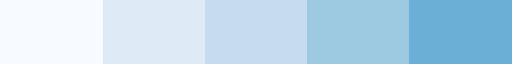

In [43]:
cmap

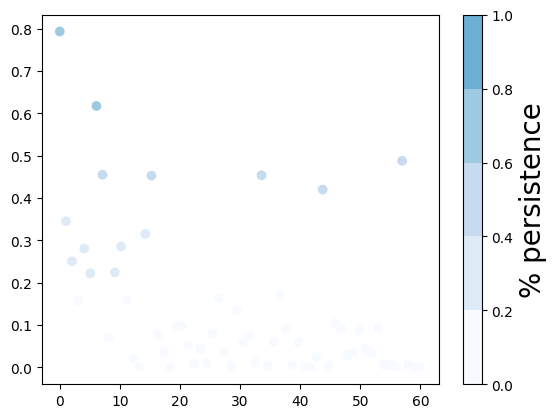

In [44]:
# plot persistence, actually done just to get the color bar for the network plot below..
plt.scatter(np.linspace(0,raw_persistence.shape[0],raw_persistence.shape[0]),raw_persistence,
            c=raw_persistence,cmap=cmap,vmin=0,vmax=1.0) # vmin/max necessary when max values are below 0.8 here
plt.colorbar(boundaries=np.linspace(0,1.0,6)).ax.set_ylabel('% persistence', fontsize=20)
plt.show()

In [45]:
# custom labels, with pocket ID (pID) starting at 1
labels={}
for key in dict_emb.keys():
    labels[key]=key+1
    
labels_dict={n:lab for n,lab in labels.items() if n in dict_emb}

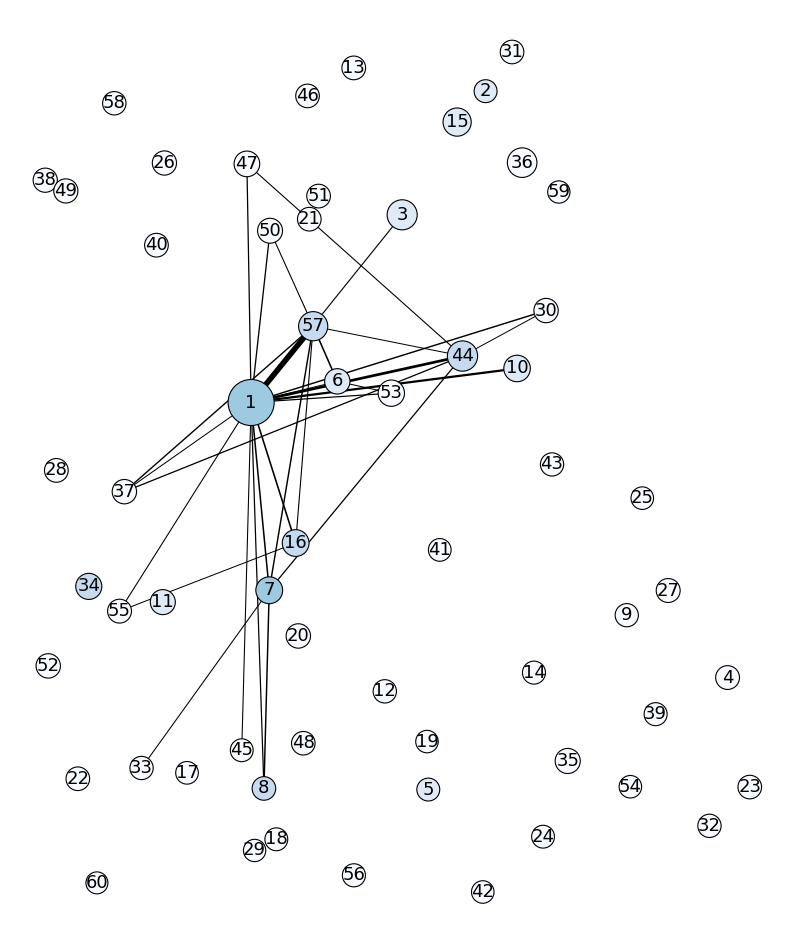

In [47]:
#plt.figure(figsize=(8,16)) # size compatible with the 3D structure for A2A
#plt.figure(figsize=(8,12)) # size compatible with the 3D structure for AR
#plt.figure(figsize=(10,12)) # size compatible with the 3D structure for EGFR

plt.figure(figsize=(10,12)) 
nx.draw_networkx_nodes(G_dynet,pos=dict_emb,node_size=scaled_vols,
                       linewidths=0.8, edgecolors = 'black', node_color=raw_persistence,cmap=cmap,vmin=0,vmax=1)

# uncomment depending on the system
## a2a
#nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=17,labels=labels_dict)
## ar
#nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=16,labels=labels_dict)
# egfr
nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=13,labels=labels_dict)



nx.draw_networkx_edges(G_dynet,pos=dict_emb,width=np.array(weights_dynet_rescaled))
plt.axis('off')
#plt.title('EGFRk DyNetAn')
#plt.show()
plt.savefig(test_folder+'netw_dynet_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

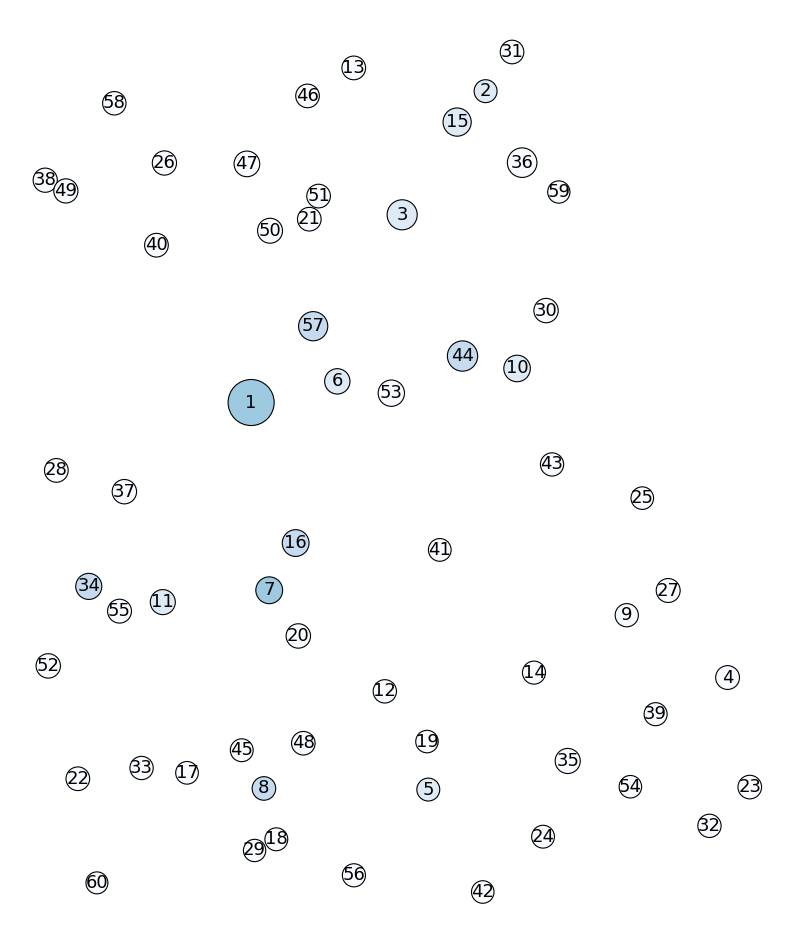

In [117]:
plt.figure(figsize=(10,12)) 
nx.draw_networkx_nodes(G_dynet,pos=dict_emb,node_size=scaled_vols,
                       linewidths=0.8, edgecolors = 'black', node_color=raw_persistence,cmap=cmap,vmin=0,vmax=1)

# uncomment depending on the system
## a2a
#nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=17,labels=labels_dict)
## ar
#nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=16,labels=labels_dict)
# egfr
nx.draw_networkx_labels(G_dynet,pos=dict_emb,font_size=13,labels=labels_dict)



#nx.draw_networkx_edges(G_dynet,pos=dict_emb,width=np.array(weights_dynet_rescaled))
plt.axis('off')
#plt.title('EGFRk DyNetAn')
#plt.show()
plt.savefig(test_folder+'netw_dynet_'+case_study+'_NODES.png', format='png', dpi=600, bbox_inches='tight')

### Print DyNet visualization stuff for VMD

### Pocket COM (only once)

In [190]:
# scale suitable for visualization in VMD
scaled_vols_VMD=scale_range(np.array(scaled_vols),0.5,3)

In [205]:
file=open(test_folder+'/VMD_pocketCOM_'+case_study+'.txt',"w")

# write pocket COM coordinates
file.write('graphics top color white \ngraphics top material Transparent \n')
for i in range(len(com_array)):
    file.write('graphics top sphere {%s %s %s} radius %s resolution 100 \n'%
               (com_array[i][0]*10,com_array[i][1]*10,com_array[i][2]*10,scaled_vols_VMD[i])) # nm to Ang

# write pocket labels
file.write('graphics top color black \n')
for i in range(len(com_array)):
    file.write('graphics top text {%s %s %s} "%s" size 1 \n'%
               (com_array[i][0]*10,com_array[i][1]*10,com_array[i][2]*10,i+1)) # nm to Ang
    
file.close()

The file created here above can be loaded in VMD from the TkConsole with:  
source VMD_pocketCOM_EGFR.txt

### Edges 

In [261]:
# get the edges corresponding to the top 30 correlations
# and scale the suitably for visualization in VMD
cutoff_2=np.sort(mat_dynet.flatten())[::-1][:60][-1] # the first 30 values of the matrix
edges_coms=[]
edges_vals=[]
for i in range(len(com_array)):
    for j in range(len(com_array)):
        if i<j:
            if mat_dynet[i][j] > cutoff_2:
                edges_coms.append([i,j])
                edges_vals.append(mat_dynet[i][j])
edges_coms=np.array(edges_coms)
edges_vals=scale_range(np.array(edges_vals),0.1,0.5) # scale suitable for visualization in VMD

In [262]:
file=open(test_folder+"VMD_edges_dynet_"+case_study+".txt","w")

for i in range(len(edges_coms)):
    file.write('graphics top cylinder {%s %s %s} {%s %s %s} radius %s\n'%
               (com_array[edges_coms[i][0]][0]*10,
                com_array[edges_coms[i][0]][1]*10,
                com_array[edges_coms[i][0]][2]*10,
                com_array[edges_coms[i][1]][0]*10,
                com_array[edges_coms[i][1]][1]*10,
                com_array[edges_coms[i][1]][2]*10,
                edges_vals[i])) # *10 to convert from nm to Ang
file.close()

The file created here above can be loaded in VMD from the TkConsole with:  
source VMD_edges_dynet_EGFR.txt

## DF analysis

This analysis uses the distance fluctuation (DF) approach introduced in [2], implemented in the script distance_fluctuation_2.1.py, that was kindly provided to us by the authors.   

In particular, the line we used to produce the files usedhere below is:  
for i in {5,10,15,20,25,30}; do python3  -ext pdb -n 305 -i ../input/multi_pdb_60 -c $i; done  
Here, -c is a required flag but is actually used only to further produce histograms, as done in previous works by the authors. This is irrelevant for our analysis, as we work directly with the two (average distance, and distance fluctuation) matrices.  
  
[2] Morra, G. et al., Modeling signal propagation mechanisms and ligand-based conformational dynamics of the Hsp90 molecular chaperone full-length dimer, _PLoS computational biology_, __2009__

In [48]:
# minimum, maximum, and average distance between pockets (in nm)
np.min(com_dmat[com_dmat!=0]),np.max(com_dmat[com_dmat!=0]),np.average(com_dmat[com_dmat!=0])

(0.15376207556200913, 5.445519974180493, 2.586126706312324)

In [51]:
# Load the distance fluctuation file
path=main_folder+case_study+'/analysis/'
X, Y, ms = np.loadtxt(path+'rmsdist_out_0_50001_CA.dat', unpack=True)

In [52]:
n_residues=traj.n_residues
n_residues

289

In [54]:
# Load the average distance file
path=main_folder+case_study+'/analysis/'
Xd, Yd, d = np.loadtxt(path+'avgdist_out_0_50001_CA.dat', unpack=True)

In [55]:
ms = np.reshape(ms, (n_residues,n_residues))
ms.shape

(289, 289)

In [56]:
d = np.reshape(d, (n_residues,n_residues))
d.shape

(289, 289)

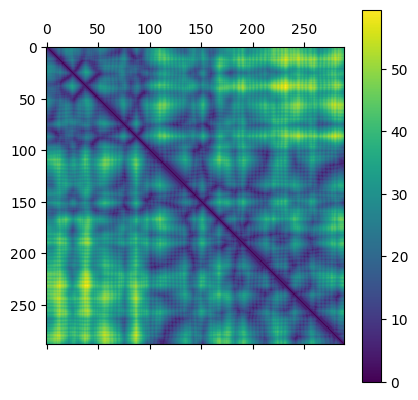

In [57]:
# plot the average distance matrix
plt.matshow(d)
plt.colorbar()
plt.show()

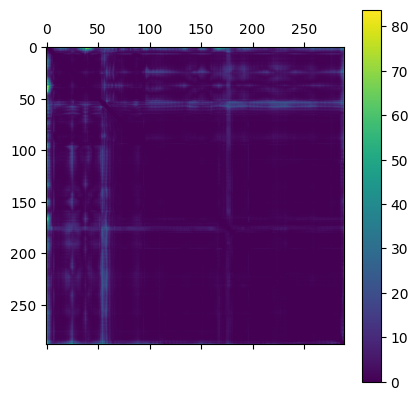

In [58]:
# plot the distance fluctuation matrix
plt.matshow(ms)
plt.colorbar()
plt.show()

In [59]:
# The average CP value for consecutive amino acids along the sequence, considering neighboring i+4 and i-4
# (i.e.the 6 flanking distances)
# NB: this is used as a cutoff to filter out local fluctuations in the distance fluctuation matrix
seq=[]
for i in range(3,ms.shape[0]-3):
    seq.append(np.sum(ms[i,i-3:i+4])/6)
    
np.average(np.array(seq))

0.10265600058892817

In [60]:
# The average CP value for residues distant more than 6 A 
np.average(ms[d>6])

2.394083658184218

In [169]:
# filter out local fluctuations in the distance fluctuation matrix with the cutoff determined above
ms_f=np.full((n_residues,n_residues),1.0)
ms_f[np.where(ms<0.10)]=ms[ms<0.10] # 0.1

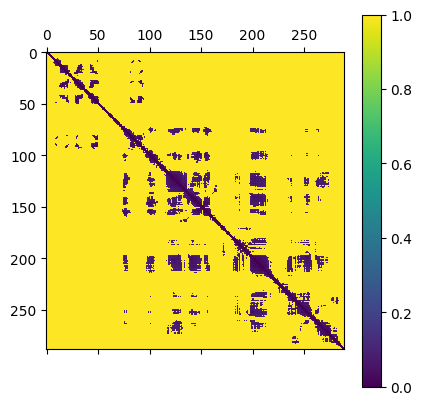

In [170]:
plt.matshow(ms_f)
plt.colorbar()
plt.show()

In [292]:
ms_f_d=np.full((n_residues,n_residues),1.0)
ms_f_d[np.where(d>8)]=ms_f[d>8] # 8
# 6-7 Angstrom is ~ the distance between one Ca i and i+4 in a alpha helix, 
# thus 8 sounds as a reasonable safe distance to exclude trivially correlated pairs

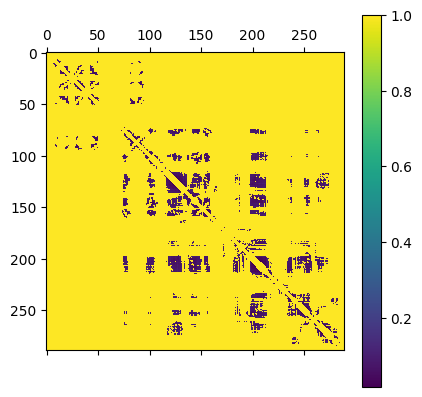

In [293]:
plt.matshow(ms_f_d)
plt.colorbar()
plt.show()

In [294]:
# mbernett get pockets (as array, required by the code window here below)
file=open(main_folder+case_study+'/analysis/pocketron_pockets_'+case_study+'.txt','r')
pockets={}
i=0
for line in file:
    atoms=np.array(line.split(),dtype='int')-1
    resids=np.unique([a.residue.index for a in traj.top.atoms if a.index in atoms])+1 # residues counted from 1
    pockets[i]=resids
    i+=1
pockets.pop(0),pockets.pop(len(pockets))

(array([5]), array([], dtype=float64))

In [295]:
# compute the DF matrix coarse grained in pockets
mat_ab=np.full((len(pockets),len(pockets)),1.0) # store non redundant, and all in a
mat_b=np.full((len(pockets),len(pockets)),1.0) # store all in b
for i in range(1,len(pockets)+1): # pockets run from 1 to 35
    for j in range(1,len(pockets)+1):
        if np.isin(pockets[i],pockets[j]).any(): # check if there is at least 1 redundant element
            p_noa=pockets[i][np.invert(np.isin(pockets[i],pockets[j]))] # pocket a with no values equal to b
            p_nob=pockets[j][np.invert(np.isin(pockets[j],pockets[i]))]
            #print(pockets[i],pockets[j])
            #print(p_noa,p_nob)
            #print()
            tmp_kl=[]
            for k in range(len(pockets[i])): # all redundants in pocket a
                for l in range(len(p_nob)):
                    if ms_f_d[pockets[i][k]-1,p_nob[l]-1]<1.0:
                        tmp_kl.append(ms_f_d[pockets[i][k]-1,p_nob[l]-1]) # -1: residues count from 0 in python
            if tmp_kl:
                mat_ab[i-1,j-1]=np.average(np.array(tmp_kl))
                #print('ab ',np.average(np.array(tmp_kl)))

            tmp_mn=[]
            for m in range(len(pockets[j])): # all redundants in pocket b
                for n in range(len(p_noa)):
                    if ms_f_d[pockets[j][m]-1,p_noa[n]-1]<1.0:
                        tmp_mn.append(ms_f_d[pockets[j][m]-1,p_noa[n]-1])
            if tmp_mn:
                mat_b[i-1,j-1]=np.average(np.array(tmp_mn))
                #print('b ',np.average(np.array(tmp_mn)))
        else: # non redundant pockets treated here
            tmp_op=[]
            for o in range(len(pockets[i])):
                for p in range(len(pockets[j])):
                    if ms_f_d[pockets[i][o]-1,pockets[j][p]-1]<1.0:
                        tmp_op.append(ms_f_d[pockets[i][o]-1,pockets[j][p]-1])
            if tmp_op:
                mat_ab[i-1,j-1]=np.average(np.array(tmp_op))
                #print('s',np.average(np.array(tmp_op)))
final_mat_new=np.minimum(mat_ab,mat_b) # min means higher signal
#np.fill_diagonal(final_mat,1) # !! so that np.exp(-final_mat) is 0 in the diagonal

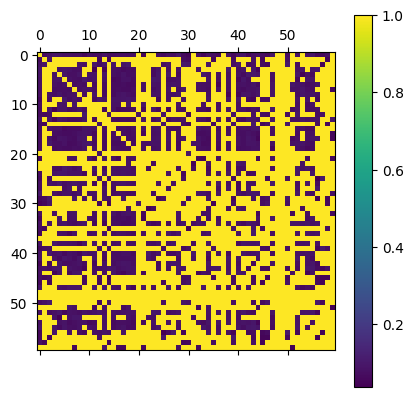

In [296]:
plt.matshow(final_mat_new)
plt.colorbar()
plt.show()

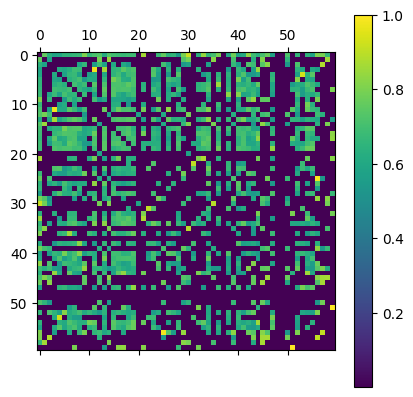

In [297]:
beta=10
plt.matshow(np.exp(-beta*final_mat_new)/np.max(np.exp(-beta*final_mat_new)))
plt.colorbar()
plt.show()

In [277]:
np.min(final_mat_new)
# since the minimum is never 0, we do not get exactly 1 as the maximum,
# thus here below we re-normalize it in the range [0,1]

0.037281

In [298]:
beta=10
mat_df=np.exp(-beta*final_mat_new)/np.max(np.exp(-beta*final_mat_new))

In [299]:
# save mat
np.savetxt(test_folder+'matrix_DF_'+case_study+'.txt',mat_df,fmt='%.9f')

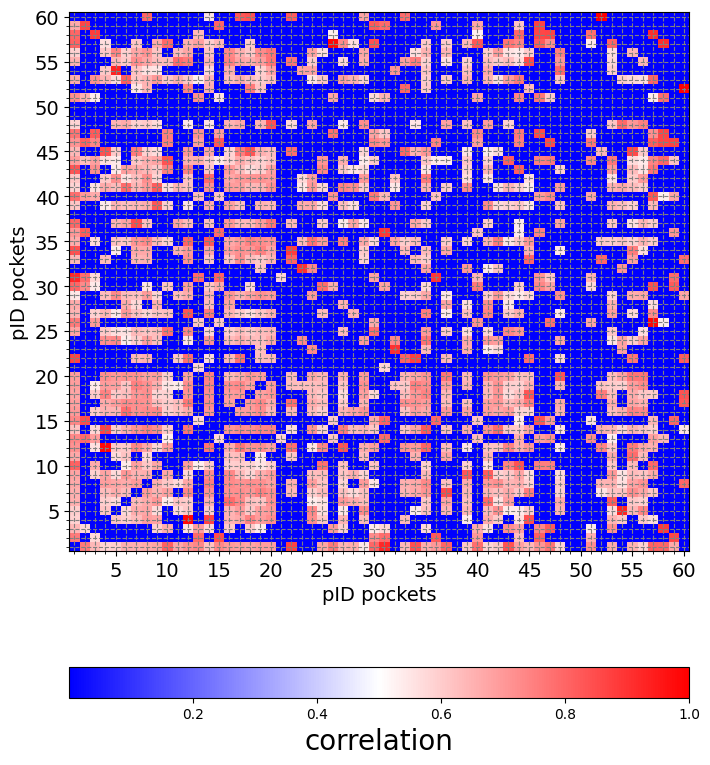

In [72]:
fig = plt.figure(figsize=(8,10))
ax = plt.axes()
cmap = mat.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

surf = ax.pcolormesh(np.linspace(1,n_pockets,n_pockets),np.linspace(1,n_pockets,n_pockets), 
                     mat_df,shading='nearest',cmap=cmap) # , vmin=0, vmax=25

plt.colorbar(surf,orientation="horizontal",pad=0.15).ax.set_xlabel('correlation', fontsize=20)

#plt.xticks(axis_labels_a2a,fontsize=14)
#plt.yticks(axis_labels_a2a,fontsize=14)
#plt.xticks(axis_labels_ar,fontsize=14)
#plt.yticks(axis_labels_ar,fontsize=14)
plt.xticks(axis_labels_egfr,fontsize=14)
plt.yticks(axis_labels_egfr,fontsize=14)

plt.xlabel("pID pockets",fontsize=14)
plt.ylabel("pID pockets",fontsize=14)
plt.gca().set_xticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.gca().set_yticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.grid(which='both',ls='--',color='gray') # major, minor, both
#plt.show()
plt.savefig(test_folder+'matrix_DF_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

In [300]:
# 
cutoff_2=np.sort(mat_df.flatten())[::-1][:60][-1]
cutoff_2

0.8306327659768913

In [301]:
mat_df_cleaned=np.zeros(mat_df.shape)
mat_df_cleaned[mat_df>cutoff_2]=mat_df[mat_df>cutoff_2]

In [302]:
#G_ar_c=nx.from_numpy_matrix(mat_ar_c_cleaned,create_using=nx.Graph)
G_df=nx.from_numpy_matrix(mat_df_cleaned,create_using=nx.Graph)

In [282]:
G_df.edges

EdgeView([(0, 21), (0, 30), (0, 33), (0, 42), (1, 14), (1, 58), (2, 57), (3, 11), (3, 13), (3, 44), (4, 53), (6, 36), (9, 43), (11, 26), (17, 44), (17, 59), (19, 47), (21, 33), (22, 31), (25, 56), (29, 56), (30, 35), (44, 54), (45, 46), (45, 57), (45, 58), (46, 57), (51, 59), (56, 57)])

In [303]:
weights_df=[G_df[u][v]['weight'] for u,v in G_df.edges]

In [304]:
weights_df_rescaled=scale_range(np.array(weights_df),0.7,4)

In [224]:
#import matplotlib as mpl
cmap = plt.cm.Blues
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist=cmaplist[:int(len(cmaplist)/2)] # actually take only a fraction of the original colormap 
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, 5)

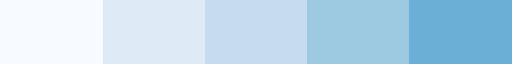

In [225]:
cmap

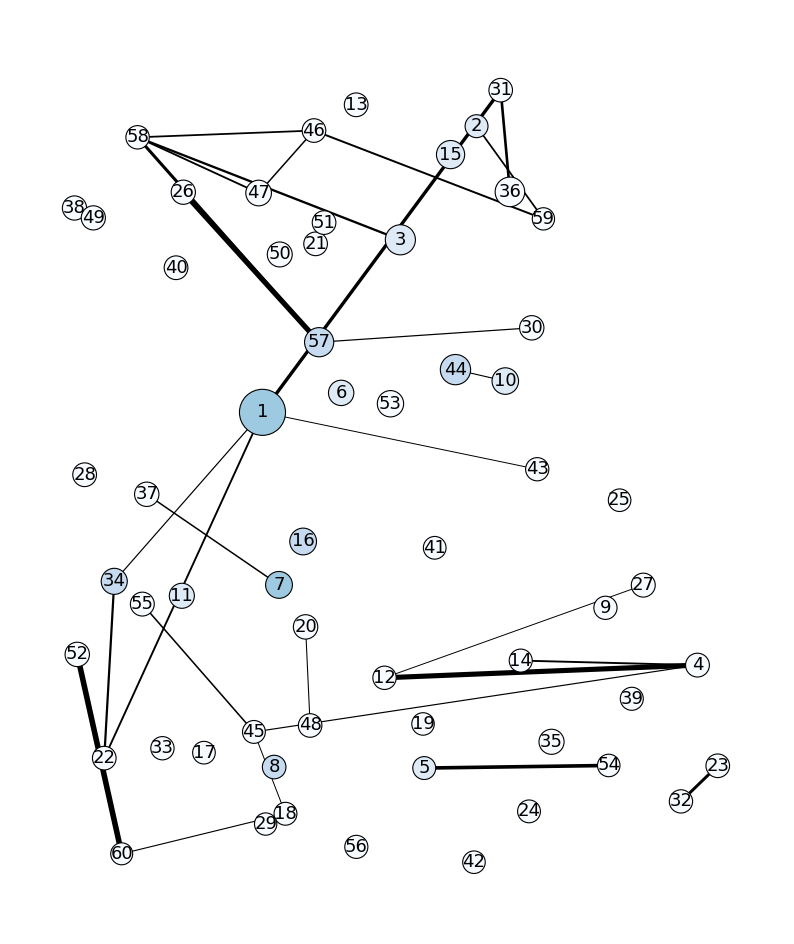

In [115]:
# 
plt.figure(figsize=(10,12))
nx.draw_networkx_nodes(G_df,pos=dict_emb,node_size=scaled_vols,
                       linewidths=0.8, edgecolors = 'black', node_color=raw_persistence,cmap=cmap,vmin=0,vmax=1)

## a2a
#nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=17,labels=labels_dict)
## ar
#nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=16,labels=labels_dict)
# egfr
nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=13,labels=labels_dict)

nx.draw_networkx_edges(G_df,pos=dict_emb,width=np.array(weights_df_rescaled))
plt.axis('off')
#plt.title('A2A CP')
#plt.show()
plt.savefig(test_folder+'netw_DF_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

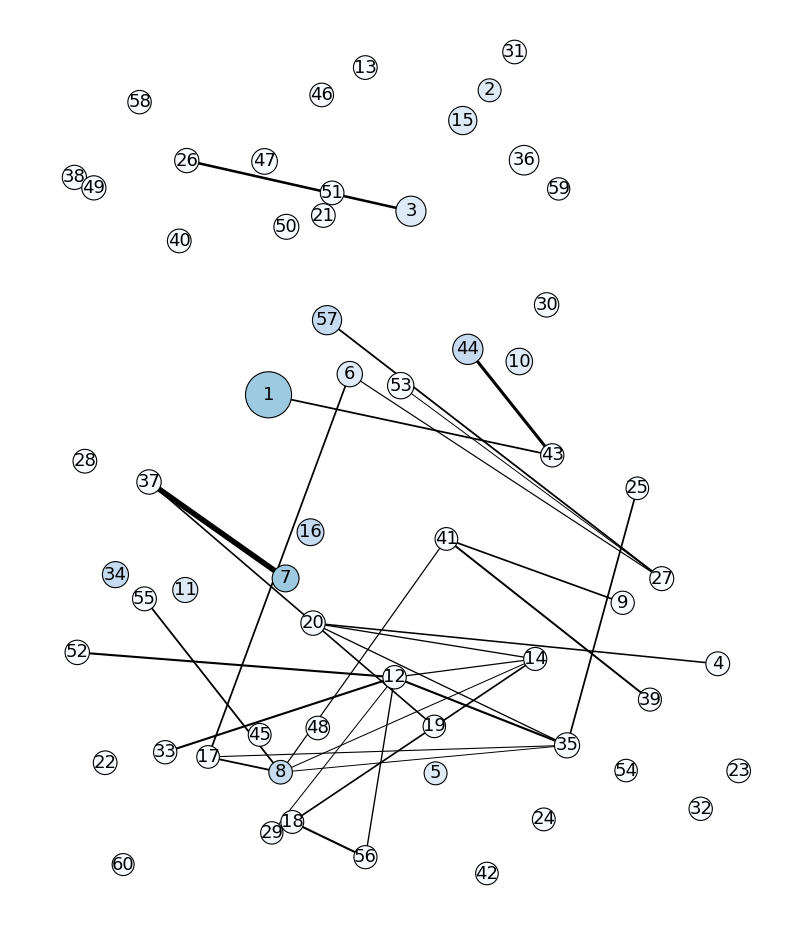

In [186]:
# to test the effect with 6, 10, 15
plt.figure(figsize=(10,12))
nx.draw_networkx_nodes(G_df,pos=dict_emb,node_size=scaled_vols,
                       linewidths=0.8, edgecolors = 'black', node_color=raw_persistence,cmap=cmap,vmin=0,vmax=1)

## a2a
#nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=17,labels=labels_dict)
## ar
#nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=16,labels=labels_dict)
# egfr
nx.draw_networkx_labels(G_df,pos=dict_emb,font_size=13,labels=labels_dict)

nx.draw_networkx_edges(G_df,pos=dict_emb,width=np.array(weights_df_rescaled))
plt.axis('off')
#plt.title('A2A CP')
#plt.show()
plt.savefig(test_folder+'netw_DF_15_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

#### testing the effect of $\beta$

In [118]:
histos_df={}
betas=[1,2,5,10,20,50]
for i in range(len(betas)):
    histos_df[betas[i]]=np.histogram(np.exp(-betas[i]*final_mat_new)/np.max(np.exp(-betas[i]*final_mat_new)),
                                            range=(-0.1,1.1),density=True,bins=30)
# divided by the maximum, ranges from 0 to 1

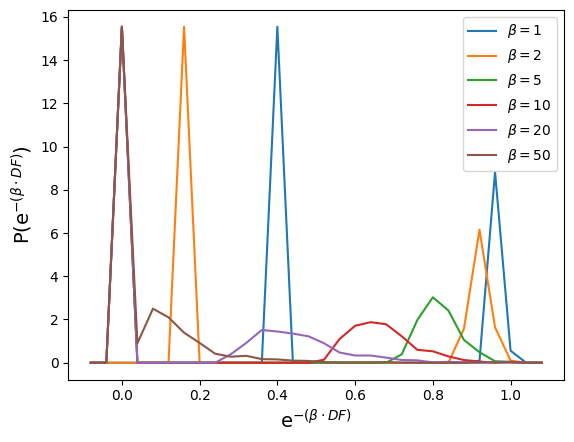

In [315]:
for i in range(len(betas)):
    plt.plot((histos_df[1][1][1:]+histos_df[1][1][:-1])/2,histos_df[betas[i]][0],
             label=r'$\beta=$%s'%betas[i])

#plt.ylim(-0.1,5)
plt.xlabel(r'e$^{-(\beta \cdot DF)}$', fontsize=14)
plt.ylabel(r'P(e$^{-(\beta \cdot DF)}$)', fontsize=14)
plt.legend(fontsize=10)
#plt.show()
plt.savefig(test_folder+'beta_df_egfr.png', format='png', dpi=600, bbox_inches='tight')

### Print DF visualization stuff for VMD

### Edges 

In [263]:
cutoff_2=np.sort(mat_df.flatten())[::-1][:60][-1] # the first 30 values of the matrix
edges_coms=[]
edges_vals=[]
for i in range(len(com_array)):
    for j in range(len(com_array)):
        if i<j:
            if mat_df[i][j] > cutoff_2:
                edges_coms.append([i,j])
                edges_vals.append(mat_df[i][j])
edges_coms=np.array(edges_coms)
edges_vals=scale_range(np.array(edges_vals),0.1,0.5) # scale suitable for visualization in VMD

In [264]:
file=open(test_folder+"VMD_edges_DF_"+case_study+".txt","w")

for i in range(len(edges_coms)):
    file.write('graphics top cylinder {%s %s %s} {%s %s %s} radius %s\n'%
               (com_array[edges_coms[i][0]][0]*10,
                com_array[edges_coms[i][0]][1]*10,
                com_array[edges_coms[i][0]][2]*10,
                com_array[edges_coms[i][1]][0]*10,
                com_array[edges_coms[i][1]][1]*10,
                com_array[edges_coms[i][1]][2]*10,
                edges_vals[i])) # *10 to convert from nm to Ang
file.close()

## Pocketron

This analysis uses the Pocketron algorithm, which has been developed in [3] and is available in BiKi Life Sciences [4].   
  
[3] La Sala, G. et al., Allosteric communication networks in proteins revealed through pocket crosstalk analysis, _ACS central science_, __2017__  
[4] Decherchi, S., BiKi life sciences: a new suite for molecular dynamics and related methods in drug discovery, _Journal of chemical information and modeling_, __2018__

In [104]:
# merge matrix
X_m,Y_m,Z_m=np.loadtxt(main_folder+case_study+'/analysis/pocketron_mergeMatrix_'+case_study+'.txt', unpack=True)
X_m = np.reshape(X_m, (len(pockets),len(pockets)))
Y_m = np.reshape(Y_m, (len(pockets),len(pockets)))
Z_m = np.reshape(Z_m, (len(pockets),len(pockets)))
Z_ms=(Z_m+Z_m.T)/2 

# split matrix
X_s,Y_s,Z_s=np.loadtxt(main_folder+case_study+'/analysis/pocketron_splitMatrix_'+case_study+'.txt', unpack=True)
X_m = np.reshape(X_m, (len(pockets),len(pockets)))
X_s = np.reshape(X_m, (len(pockets),len(pockets)))
Y_s = np.reshape(Y_m, (len(pockets),len(pockets)))
Z_s = np.reshape(Z_m, (len(pockets),len(pockets)))
Z_ss=(Z_s+Z_s.T)/2

# merge/split average
ms_avg= (Z_ms+Z_ss)/2 

In [105]:
X_m = np.reshape(X_m, (len(pockets),len(pockets)))
Y_m = np.reshape(Y_m, (len(pockets),len(pockets)))
Z_m = np.reshape(Z_m, (len(pockets),len(pockets)))

In [106]:
mat_pk=copy.deepcopy(ms_avg)
np.fill_diagonal(mat_pk,0)
mat_pk=mat_pk/np.max(mat_pk)

In [84]:
# save the Pocketron correlation matrix
np.savetxt(test_folder+'matrix_pock_'+case_study+".txt",mat_pk,fmt='%.9f')

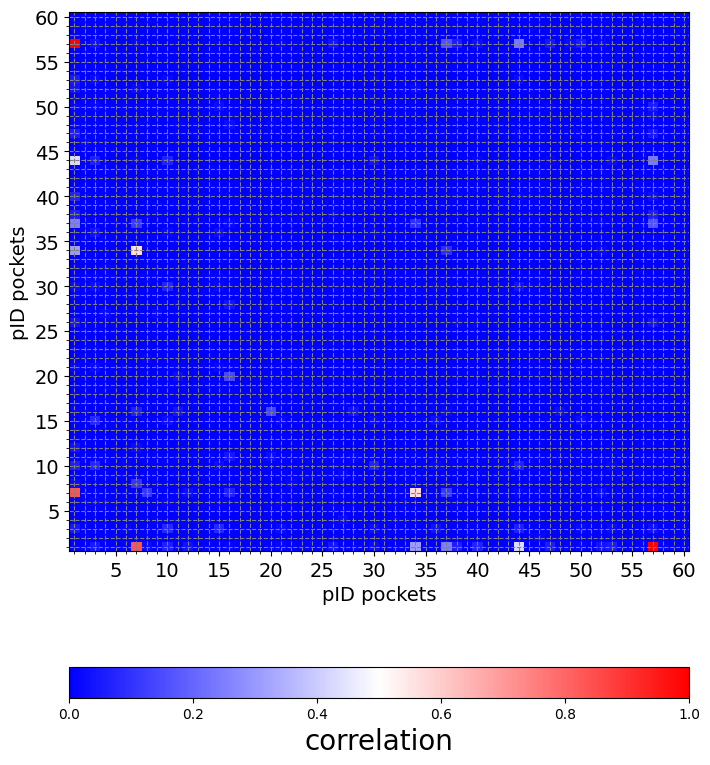

In [85]:
fig = plt.figure(figsize=(8,10))
ax = plt.axes()
cmap = mat.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"])

surf = ax.pcolormesh(X_s,Y_s,mat_pk,shading='nearest',cmap=cmap) # , vmin=0, vmax=25

plt.colorbar(surf,orientation="horizontal",pad=0.15).ax.set_xlabel('correlation', fontsize=20)

# uncomment depending on the system

#plt.xticks(axis_labels_a2a,fontsize=14)
#plt.yticks(axis_labels_a2a,fontsize=14)
#plt.xticks(axis_labels_ar,fontsize=14)
#plt.yticks(axis_labels_ar,fontsize=14)
plt.xticks(axis_labels_egfr,fontsize=14)
plt.yticks(axis_labels_egfr,fontsize=14)

plt.xlabel("pID pockets",fontsize=14)
plt.ylabel("pID pockets",fontsize=14)
plt.gca().set_xticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.gca().set_yticks(np.linspace(1,len(pockets),len(pockets),dtype='int'),minor=True)
plt.grid(which='both',ls='--',color='gray') # major, minor, both
#plt.show()
plt.savefig(test_folder+'matrix_pock_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

In [107]:
cutoff_2=np.sort(mat_pk.flatten())[::-1][:60][-1]
cutoff_2

0.037934421628701066

In [108]:
mat_pk_cleaned=np.zeros(mat_pk.shape)
mat_pk_cleaned[mat_pk>cutoff_2]=mat_pk[mat_pk>cutoff_2]

In [109]:
G_pk=nx.from_numpy_matrix(mat_pk_cleaned,create_using=nx.Graph)

In [110]:
weights_pk=[G_pk[u][v]['weight'] for u,v in G_pk.edges]

In [111]:
weights_pk_rescaled=scale_range(np.array(weights_pk),0.7,4)

In [112]:
#import matplotlib as mpl
cmap = plt.cm.Blues
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist=cmaplist[:int(len(cmaplist)/2)] # actually take only a fraction of the original colormap 
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, 5)

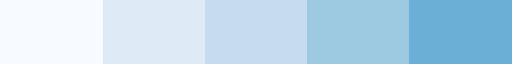

In [113]:
cmap

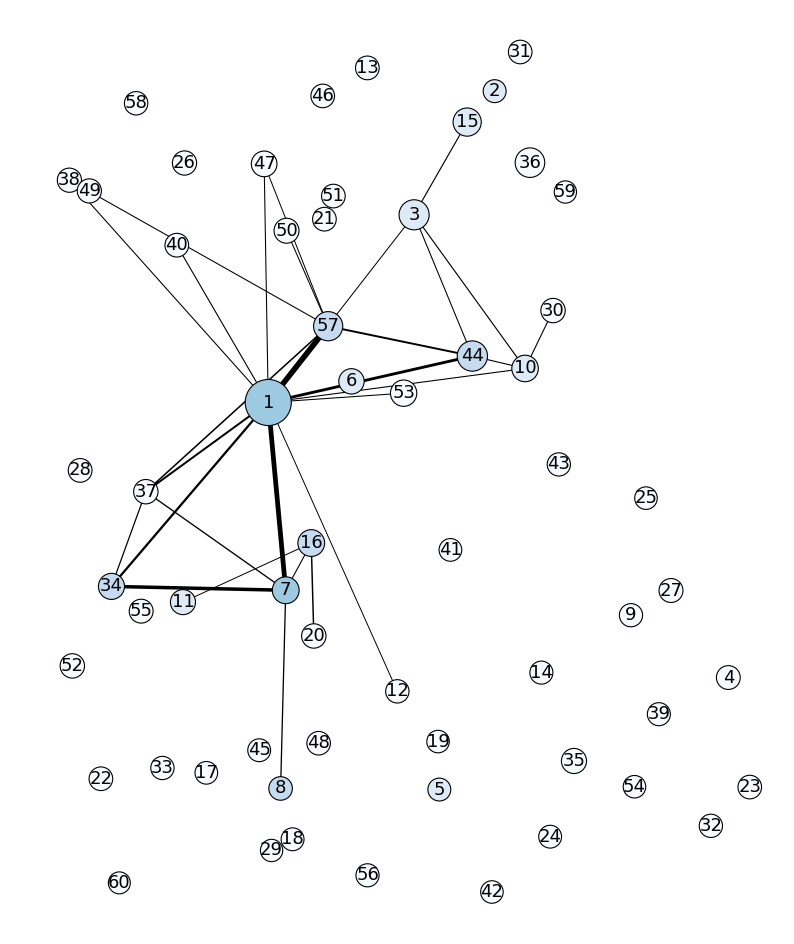

In [116]:
plt.figure(figsize=(10,12))
nx.draw_networkx_nodes(G_pk,pos=dict_emb,node_size=scaled_vols,
                       linewidths=0.8, edgecolors = 'black', node_color=raw_persistence,cmap=cmap,vmin=0,vmax=1)
## a2a
#nx.draw_networkx_labels(G_pk,pos=dict_emb,font_size=17,labels=labels_dict)
## ar
#nx.draw_networkx_labels(G_pk,pos=dict_emb,font_size=16,labels=labels_dict)
# egfr
nx.draw_networkx_labels(G_pk,pos=dict_emb,font_size=13,labels=labels_dict)

nx.draw_networkx_edges(G_pk,pos=dict_emb,width=np.array(weights_pk_rescaled))
plt.axis('off')
#plt.title('A2A Pocketron')
#plt.show()
plt.savefig(test_folder+'netw_pock_'+case_study+'.png', format='png', dpi=600, bbox_inches='tight')

### Print Pocketron visualization stuff for VMD

### Edges 

In [265]:
cutoff_2=np.sort(mat_pk.flatten())[::-1][:60][-1] # the first 30 values of the matrix
edges_coms=[]
edges_vals=[]
for i in range(len(com_array)):
    for j in range(len(com_array)):
        if i<j:
            if mat_pk[i][j] > cutoff_2:
                edges_coms.append([i,j])
                edges_vals.append(mat_pk[i][j])
edges_coms=np.array(edges_coms)
edges_vals=scale_range(np.array(edges_vals),0.1,0.5) # scale suitable for visualization in VMD

In [266]:
file=open(test_folder+"VMD_edges_pock_"+case_study+".txt","w")

for i in range(len(edges_coms)):
    file.write('graphics top cylinder {%s %s %s} {%s %s %s} radius %s\n'%
               (com_array[edges_coms[i][0]][0]*10,
                com_array[edges_coms[i][0]][1]*10,
                com_array[edges_coms[i][0]][2]*10,
                com_array[edges_coms[i][1]][0]*10,
                com_array[edges_coms[i][1]][1]*10,
                com_array[edges_coms[i][1]][2]*10,
                edges_vals[i])) # *10 to convert from nm to Ang
file.close()

Original draft of the Notebook by riccardo.aguti2@unibo.it and mattia.bernetti@iit.it  
Final review and editing by mattia.bernetti@iit.it